# 📺 Netflix Recommendation System Project

## **Project Overview**
In this project, we are building a **Netflix-style movie recommendation system** using real-world data. The goal is to predict **which movies a user might like** based on their past ratings and the ratings of other users.

We will focus on:

1. **Data Understanding & Cleaning**  
   - The dataset comes from the **Netflix Prize competition**, containing millions of ratings.  
   - Data is messy: movie IDs are listed separately, ratings are in text format, and there are missing or duplicate values.  

2. **Exploratory Data Analysis (EDA)**  
   - Understand the distribution of ratings.  
   - Find top-rated movies and active users.  
   - Visualize sparsity of the user-movie matrix.  

3. **Building the Recommendation System**  
   - Use **Model-based Collaborative Filtering**  technique.  
   - Implement **SVD (Singular Value Decomposition)** to handle sparse user-movie matrices.  
   - Use the **Surprise library** for easy model training, prediction, and evaluation.  

4. **Evaluation**  
   - Evaluate the model performance using **RMSE (Root Mean Squared Error)**.  
   - Test how well the system predicts ratings for unseen movies.  

5. **Generating Recommendations**  
   - Recommend top movies to a user they haven’t watched yet.  
   - Optionally, compare recommendations for multiple users.  

---

## **Key Concepts in This Project**
- **User-Item Matrix:** Table where rows are users, columns are movies, and cells are ratings.  
- **Collaborative Filtering:** Recommending movies based on **similar users**.  
- **SVD:** Reduces a large, sparse matrix into **latent factors** representing user and movie features.  
- **Surprise Library:** Python library to simplify **building and evaluating recommendation systems**.  

---

## **Why This Project is Useful**
- Real-world applications: Netflix, Amazon, Spotify, YouTube, etc.  
- Helps understand **how big tech recommends content** using user behavior.  
- Introduces **data cleaning, matrix factorization, and model evaluation** in a real dataset.  

---



### Importing basic libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---------------

## Data Cleaning & Transformation

### Fixing the parsing problem of dataset 

In [4]:
df = pd.read_csv('combined_data_1.txt.zip', header=None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [5]:
df['Movie_Id'] =df['Cust_Id'].where(df['Cust_Id'].str.endswith(':'), pd.NA)

In [6]:
df['Movie_Id']= df['Movie_Id'].ffill()

In [7]:
df.dropna(inplace=True)

In [8]:
df['Movie_Id']= df['Movie_Id'].str.replace(':','')

In [9]:
df = df.astype('int')

In [10]:
df

,Cust_Id,Rating,Movie_Id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1
...,...,...,...
24058258,2591364,2,4499
24058259,1791000,2,4499
24058260,512536,5,4499
24058261,988963,3,4499


#### now all the columns are ready for analysis

## Sanity Check

In [11]:
df.isnull().sum()


Cust_Id     0
Rating      0
Movie_Id    0
dtype: int64

In [12]:
df.duplicated().sum()

0

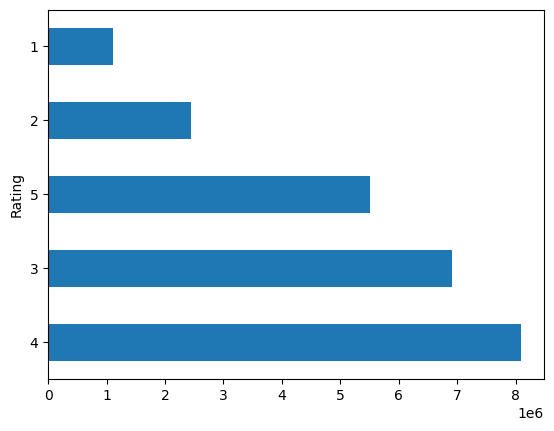

In [13]:
df['Rating'].value_counts().plot(kind='barh')
plt.show()

In [14]:
df['Cust_Id'].nunique()

470758

In [15]:
df['Movie_Id'].nunique()

4499

In [16]:
# conda install -c conda-forge scikit-surprise --yes

In [17]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


In [18]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

In [19]:
train, test = train_test_split(data, test_size=0.2)

In [20]:
model = SVD()
model.fit(train)

In [59]:
pred = model.test(test)

In [22]:
accuracy.rmse(pred)

RMSE: 0.9003


0.9003050288740826

In [23]:
titles=[]
with open('movie_titles.csv',encoding="cp1252") as f:
    for line in f:
        title = line.strip().split(',',2)
        titles.append(title)

In [24]:
df_titles = pd.DataFrame(titles, columns=['Movie_Id', 'Year', 'Title'])
df_titles['Movie_Id'] =df_titles['Movie_Id'].astype('int')
df_titles

,Movie_Id,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [63]:
act_pred = [i[2:4] for i in pred]
pred_table = pd.DataFrame(act_pred, columns=['Actual', 'Predicted']).head(10)
pred_table['diff'] = abs(pred_table['Actual'] - pred_table['Predicted'])
print("MAE: ", pred_table['diff'].mean())
pred_table

MAE:  0.4372914048730836


,Actual,Predicted,diff
0,5.0,4.908919,0.091081
1,3.0,3.458672,0.458672
2,5.0,3.997624,1.002376
3,5.0,5.000000,0.000000
4,3.0,4.333360,1.333360
5,4.0,3.511891,0.488109
6,3.0,3.028307,0.028307
7,3.0,2.640337,0.359663
8,3.0,3.361014,0.361014
9,4.0,4.250332,0.250332
